# Experimenting with Fully Connected Networks for Predicting Depth From A Single Image

### Graeme Stroud


# Abstract

This project will examine two deep neural network  architectures for the task of estimating the depth of a scene from a single image. Both architectures have a pretrained ResNet50 network feeding directly into another deep network. One architecture uses a simple convolutional network with upsampling, while the other uses more advanced upsampling blocks. The networks learn using the same losses, and two evalution metrics. The simple network makes reasonable predictions and performs well with these evaluation metrics, but undesirably my implementation of the advanced model fails to do any better.


# 1. Introduction

Computing depth from a single image is a difficult task. With multiple images, a correspondence can be established, leading to accurate estimates of depth. From a single image, cues from image features such as  "line angles and perspective, object sizes, image position, and atmospheric effects" [1] would be useful for determining depth. There have been many attempts at tackling this problem [1][2][3][4]. This project implements the neural network architecture found in [2], as well as something like what is found in [1]. The architectures use pretrained ResNet50 networks to find global features of the images, and an upscaling network to refine the ResNet output and to make the prediction. Multiple evaluation metrics are used in both papers, and I will be using two of them to determine the success of my implementation. 

First, given depth prediction $y$ for one image, and its target $t$, the threshold evaluation with parameter $\delta$ is defined as:

$$ \frac{1}{WH}\sum\limits_{p} I\{\max(y_p/t_p, t_p/y_p) < \delta\}$$

where $p$ is any pixel of the image and $W,H$ are the dimensions of the image/target. That is, it asks which percentage of pixels have a depth prediction that is "close", where "close" measures the multiplicative factor between prediction and target. The average is then  taken over all test images.


The second measure is Root Mean Square Error (RMSE), which is simply:

$$ \sqrt{\frac{1}{|T|} \sum\limits_{(y,t)\in T}\| y-t \|_2^2 }$$

where $T$ is the predictions/targets for the test set. Whereas the threshold measure gauges if values are close enough, RMSE should give a sense as to how well or poor our total pixel predictions are.

Both authors used the NYU depth dataset v2 [3] for their training and evaluation. While other datasets have been used for this problem, I will be strictly looking at the NYU dataset. The network in the second paper [2] outperforms the network in the first [1], under the two evaluations for the NYU dataset (as well as for other evaluations). Unfortunately and unexpectedly, my implementation of the second network fails to produce results that are better than the first. 

| Test Metric        | Eigen and Fergus [1] | Eigen and Rob Fergus [4] | Laina et al. [2] |
| ------------- |:-------------:|:---: | ---------:|
| $\delta_1 = 1.25$      | 0.611| 0.769 |  0.811 |
| $\delta_2 = 1.25^2$ | 0.887| 0.950      |   0.953 |
| $\delta_3 = 1.25^3$ | 0.971| 0.988      |    0.988|
| RMSE | 0.285| 0.214      |    0.195 |
   

Table 1 : Comparisons of the evaluation metrics between the two papers. Three different values of $\delta$ are used. For the threshold metric: the larger the better. For RMSE: the smaller the better. The authors of the first paper improved their results with [4]. However, I am sticking with the architecture used in their first paper.

<br>


As suggested, the project is done within a Jupyter notebook. I used Google Colab to take advantage of the GPU runtime.  Sections will include any related code. 

Section 2 contains the code for data preprocessing. Section 3 describes my attempt at an architecture, partially inspired by [1], and provides the implementation. Section 4 describes the architecture of the network from [2] and provides the implementation. Section 5 has the code for testing the models on the NYU depth dataset, with the analysis. 

Note: I host the images of my report on my CS webspace, in order for them to be visible in the report while using Colab. So if you're offline, you won't see the images in report. They can also be found in the images folder. 

# 2. Data preprocessing

This section primarily contains code, with some brief descriptions of what is happening. Subsection 2 (Data Augmentation) goes into a bit more detail than the other subsections.

Papers on single image depth estimation [1][2] have used the NYU depth dataset v2 [3]. Each image has a target, with the same dimensions as the image, but with only one channel, which stores the depth of the object in the scene. The data is fully labelled and stored in a handy matlab file. However Silberman et al. [3] provide [the full raw data](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2) that is only partially labelled. Eigen, Puhrsch and Fergus [2] suggest masking out the target where the values were unknown. This seems like a reasonable task to complete, however I did not even figure out how to read the raw data into a Python. Therefore, the dataset is smaller than is ideal. Data augmentations will help alleviate this problem slightly. The authors also have a recommended train/test split in a separate matlab file, which I follow.


## Downloading and loading the data

In [ ]:
import os
import pdb
import argparse
import matplotlib.pyplot as plt

from six.moves.urllib.request import urlretrieve
import sys

# This code was taken from a course I took during undergrad at UofT
# http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf
# It simply downloads dataset files to Google Colab.
def get_file(fname,
             origin,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    fpath = os.path.join(datadir, fname)
    
    print(fpath)

    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    return fpath


path = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
path_to_depth = get_file(fname='nyu_depth_v2_labeled.mat', 
                         origin=path)

path = 'http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat'
path_to_split = get_file(fname='train_test_split.mat', 
                         origin=path)


data/nyu_depth_v2_labeled.mat
data/train_test_split.mat


In [ ]:
%matplotlib inline

import skimage.io as io
import numpy as np
import h5py
from scipy.io import loadmat

# For whatever reason, neither of these ways to read in .mat files works for
# both of the files, so both ways have to be used.

# Loading data
with h5py.File(path_to_depth) as f:
  imgs = f['images'][()]
  depths = f['depths'][()]

# Loading arrays that give recommended train/test.
split_dict = loadmat(path_to_split)
train_indices = split_dict['trainNdxs']
test_indices = split_dict['testNdxs']
  

A sample image and depth map.

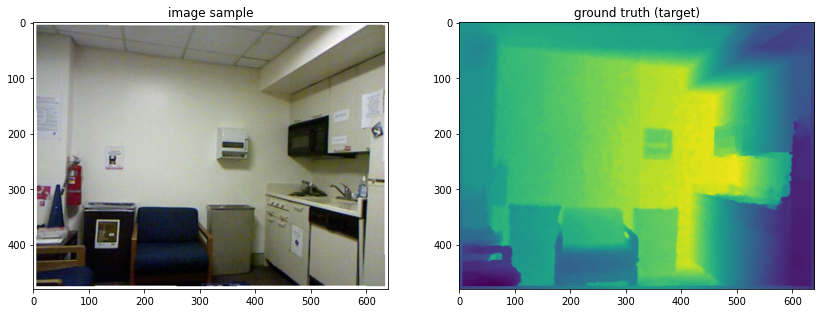

In [ ]:
img = imgs[0]

img = np.transpose(img, (2,1,0))

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample')
ax.imshow(img)

depth = depths[0]
depth = np.transpose(depth, (1,0))

ax = fig.add_subplot(1,2,2)
plt.title('ground truth (target)')
ax.imshow(depth)
#plt.colorbar(cax=ax) Couldn't get this working...


## Data Augmentation

The data gets augmented in order to increase the variety. This is all in hopes to improve the generalization of the model.

Augmentations include random horizontal flips and small rotations. Eigen and Fergus [1] suggests additional augmentations. I used their suggestion to randomly modify the colors of all image pixels by a factor of $c \in[0.8, 1.2]$, which should not change the depth of that image.

The images are cropped in order to mask out the blank pixel values after the rotations, then resized to be 304 by 228.


In [ ]:
from skimage.transform import resize, rotate
import random

train_imgs = np.empty([len(train_indices), 3, 228, 304])
train_targets = np.empty([len(train_indices), 228, 304])

test_imgs = np.empty([len(test_indices), 3, 228, 304])
test_targets = np.empty([len(test_indices), 228, 304])

# Input: an image of size 640x480
# Output: the image cropped, of the same aspect ratio (4:3)
#         where 4k pixels removed from left/right boundary
#           and 3k pixels removed from top/bottom boundary
def crop(image, k=10):
  return image[4*k:640-4*k, 3*k:480-3*k]

def modify_color(img):
  # random number between 0.8 and 1.2
  c = random.random() * 0.4 + 0.8
  return c*img

def random_flip(img, target):
  r = random.randint(0, 1)
  if r:
    return S[:, ::-1], T[::-1]
  return S, T

def random_rotate(img, target):
  # Random angle between -5 and 5 degrees to rotate image/target by.
  r = random.random() * 10 - 5
  return rotate(img, r, resize=False), rotate(target, r, resize=False)

# Training set
for i in range(len(train_indices)):
    S = np.squeeze(imgs[train_indices[i] - 1])   
    T = np.squeeze(depths[train_indices[i] - 1])

    S,T = random_flip(S, T)
    
    S = np.transpose(S, (1, 2, 0))
    S,T = random_rotate(S, T)
    
    # Hides missing pixel values after rotation
    S = crop(S)
    S = resize(S, (304, 228))
    T = crop(T)
    T = resize(T, (304, 228))

    S = np.transpose(S, (2, 1, 0))
    S = modify_color(S)
    T = np.transpose(T, (1, 0))

    train_imgs[i] = S
    train_targets[i] = T

    # Other suggestions from [1] (did not implement)
    #Scale
    #Translation
    


# Test set
for i in range(len(test_indices)):
    S = np.squeeze(imgs[test_indices[i] - 1])   
    T = np.squeeze(depths[test_indices[i] - 1])

    S = np.transpose(S, (1, 2, 0))
    S = crop(S)
    T = crop(T)
    S = resize(S, (304, 228))
    T = resize(T, (304, 228))
    
    S = np.transpose(S, (2, 1, 0))
    T = np.transpose(T, (1, 0))

    test_imgs[i] = S
    test_targets[i] = T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


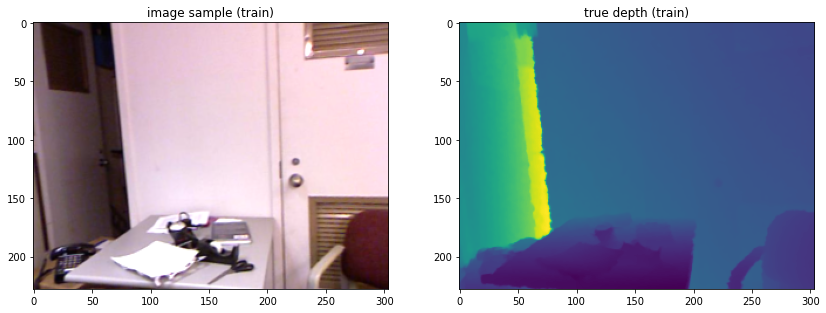

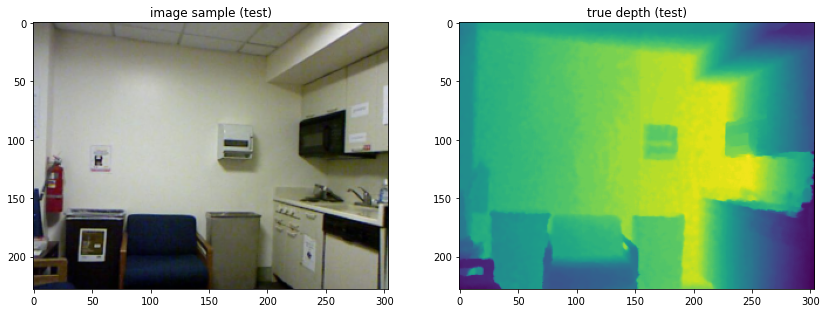

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample (train)')

z = train_imgs[0]
z = np.transpose(z, (1,2,0))

ax.imshow(z)
ax = fig.add_subplot(1,2,2)
plt.title('true depth (train)')
z = train_targets[0]
ax.imshow(z)



fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample (test)')

z = test_imgs[0]
z = np.transpose(z, (1,2,0))

ax.imshow(z)
ax = fig.add_subplot(1,2,2)
plt.title('true depth (test)')
z = test_targets[0]
ax.imshow(z)

## Constructing the data loaders

In [ ]:
import torch        
from torch.utils.data import DataLoader

class MyDataSet(torch.utils.data.Dataset):
  def __init__(self, imgs, targets):
    super(MyDataSet, self).__init__()
    self.imgs = imgs
    self.targets = targets

  def __len__(self):
    return self.imgs.shape[0]

  def __getitem__(self, i):
    return self.imgs[i], self.targets[i] 


def loader(train_imgs, train_targets, test_imgs, test_targets):
    
    train_dataset = MyDataSet(train_imgs, train_targets)
    test_dataset = MyDataSet(test_imgs, test_targets)
    overfit_dataset = MyDataSet(train_imgs[:1], train_targets[:1])

    train_dloader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, num_workers=1)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, num_workers=1)
    overfit_dloader = DataLoader(dataset=overfit_dataset, batch_size=1, shuffle=False, num_workers=1)
    
    return train_dloader, test_dloader, overfit_dloader

train_dloader, test_dloader, overfit_dloader = loader(train_imgs, train_targets, test_imgs, test_targets)


# 3. Neural Network \#1

The first network was inspired by the architecture from [1]. See the code below (class DepthNetwork). However, the current implementation is more based on the network from (my version of) Assignment 4. The main reason for the change was the authors recommend pretrained weights in their "coarse" network (see Figure 1) on the ImageNet dataset [5], but this wasn't something that I wanted to spend time on. I'd ideally wanted to use a pretrained model, like pretrained ResNet50 implemented in PyTorch, but it is not as easy as replacing the coarse network with ResNet50. And without pretraining the coarse network, it seemed like it performed worse than my other implementation with ResNet50. All I intended was to have a simple network to compare to the more complicated network from [2], so I just kept the better of the two. For completeness, I included my attempt at implementing the network from [1], which does work and trains (albeit trains poorly).

<img src="https://cs.uwaterloo.ca/~grstroud/CS684/arch1.png">

Figure 1: The basic architecture from [1].

<br>

The architecture I have is fairly simple.

- The images are first fed through ResNet50 (without the last fully connected layers, etc...), which reduces the image dimensions by around a factor of 32. There are 2048 features learned.

- The features are fed into a sequence of convolution/upsample layers, increasing the dimensions and decreasing the feature dimension along the way. 

- Skip connections were considered as in [1], but the results seemed sufficient, so this was not explored at all. (This would have been the next thing I attempted, if I had more time. Instead, I ended up spending the day before the deadline getting my second network to work better.)

This network and the second network will make log-predictions. If the <i>forward</i> function is called during training, the loss is computed with the output of the network and the log of the target depths. If the <i>forward</i> function is called during evaluation, exp of the output is returned to get the depth predictions.

In [ ]:
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.transforms as transforms

USE_GPU = True


In [ ]:
import torchvision.models as models

def createLayer(size_in, size_out, kernel, stride,  relu=True, padding=0):
  if relu:
    return nn.Sequential(*[nn.Conv2d(size_in, size_out, kernel, stride, padding=padding, dilation=1), nn.ReLU(), nn.BatchNorm2d(size_out)])
  return nn.Sequential(*[nn.Conv2d(size_in, size_out, kernel, stride, padding=padding, dilation=1), nn.BatchNorm2d(size_out)])


class DepthNetwork(nn.Module):
  def __init__(self, loss=None):
    super(DepthNetwork, self).__init__()
    self.loss = loss
    
    image_modules = list(models.resnet50(pretrained=True).children())[:-2]

    self.resnet50 = nn.Sequential(*image_modules)

    self.layer1 = createLayer(2048, 1024, 1, 1, relu=False)
    self.layer2 = createLayer(1024, 512, 3, 1)
    self.layer3 = createLayer(512, 256, 3, 1)
    self.layer4 = createLayer(256, 128, 3, 1)
    self.layer5 = createLayer(128, 64, 3, 1)
    
    self.layer6 = nn.Conv2d(64, 1, 1, 1, padding=0, dilation=1)

  def forward(self, images, depths=None):
    
    x = self.resnet50(images)
    x = self.layer1(x)
    x = F.interpolate(x, scale_factor = 2, mode='bilinear')
    
    x = self.layer2(x)
    x = F.interpolate(x, scale_factor = 2, mode='bilinear')
    
    x = self.layer3(x)
    x = F.interpolate(x, scale_factor = 2, mode='bilinear')
    
    x = self.layer4(x)
    x = F.interpolate(x, scale_factor = 2, mode='bilinear')
    
    x = self.layer5(x)
    x = F.interpolate(x, scale_factor = 2, mode='bilinear')
    
    x = self.layer6(x)
    
    size_img = (images.size()[2], images.size()[3])
    x = F.interpolate(x, size = size_img, mode='bilinear')
    x = torch.mean(x, 1)
    
    if depths is not None: # self.training
      return self.loss(x, torch.log(depths))
    return torch.exp(x)


# 4. Neural Network \#2

The second architecture is based off of the paper from [2]. See the code in the class AdvancedNetwork. Their architecture is pictured below.

<img src="https://cs.uwaterloo.ca/~grstroud/CS684/arch2.png">

Figure 2 : Architecture from [2]

<br>

The first layers (on the first two rows of Figure 2) are ResNet50 without the fully connected layer, which in PyTorch, is fairly simple to implement. The weights are pretrained on the ImageNet dataset [5].  The fully connected layer gets replaced with a sequence of "Up-Convolutions" (row 3 of Figure 2).

The authors proposed different kinds of Up-Convolutions: standard up-convolutions and "up-projections", as illustrated in Figure 3. Figure 3 (c) illustrates the design I used. After some experimentation with Batch Normalization and Dropout, I found that adding Batch Normalization to the ends of these  layers improved my results.

<img src="https://cs.uwaterloo.ca/~grstroud/CS684/upproj.png">

Figure 3 : The different upsampling layers experimented with in [2]. They use (d), I use (c).

<br>

Ultimately, this architecture is similar to the first one,  except it uses more advanced upsampling layers.

In [ ]:
import torchvision.models as models

def createLayer(size_in, size_out, kernel, stride,  relu=True,padding=0):
  if relu:
    return nn.Sequential(*[nn.Conv2d(size_in, size_out, kernel, stride, padding=padding, dilation=1), nn.ReLU(), nn.BatchNorm2d(size_out)])
  return nn.Sequential(*[nn.Conv2d(size_in, size_out, kernel, stride, padding=padding, dilation=1), nn.BatchNorm2d(size_out)])

class UpConvLayer(nn.Module):
  def __init__(self, size_in):
    assert size_in % 4 == 0
    super(UpConvLayer, self).__init__()
    
    # Slightly different from what Figure 3 is suggesting, which I wasn't sure
    # how to implement.
    self.unpool = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    self.layer1 = nn.Sequential(*[nn.Conv2d(size_in, size_in//2, 5, padding=2), 
                                  nn.ReLU(), 
                                  nn.Conv2d(size_in//2, size_in//4, 3, padding=1)])
    self.layer2 = nn.Conv2d(size_in, size_in//4, 5, padding=2)
    
    self.bn = nn.BatchNorm2d(size_in//2)

  def forward(self, images):
    y = self.unpool(images)
    x = self.layer1(y)
    y = self.layer2(y)
    x = torch.cat((x,y), 1)

    x = self.bn(x)
    
    return F.relu(x)


class AdvancedNetwork_manual(nn.Module):
  
  def __init__(self):
    self.layer1 = createLayer((3, 64, kernel, stride))


class AdvancedNetwork(nn.Module):
  def __init__(self, loss):
    super(AdvancedNetwork, self).__init__()
    self.loss = loss
    
    image_modules = list(models.resnet50(pretrained=True).children())[:-2]

    self.resnet50 = nn.Sequential(*image_modules)

    self.layer1 = createLayer(2048, 1024, 1, 1, relu=False)
    self.layer2 = UpConvLayer(1024)
    self.layer3 = UpConvLayer(512)
    self.layer4 = UpConvLayer(256)
    self.layer5 = UpConvLayer(128)


    # Experimenting with different layer 5 type to see if it gets a better result.
    #self.layer5 = createLayer(128, 64, 3, 1, padding=1)
            #Note to self: Change padding based on what type layer5 is      
    self.layer6 = nn.Conv2d(64, 1, 1, 1, padding=0, dilation=1)


  def forward(self, images, depths=None):
    
    x = self.resnet50(images)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    
    size_img = (images.size()[2], images.size()[3])
    x = F.interpolate(x, size = size_img, mode='bilinear')

    x = self.layer6(x)
    
    x = torch.mean(x, 1) # squeeze, i.e. remove feature layer
    
    if depths is not None: # self.training
      return self.loss(x, torch.log(depths))
    return torch.exp(x)


# 5. Results

The two networks are trained on the NYU depth training set. Each network's upsampling layers are initialized with random weights (the default behaviour in PyTorch). They are trained for 10 epochs, which takes less than an hour. While testing, the second network used too much CUDA memory with a large batch size, so a batch size of 10 was chosen. The networks share the same loss function. 

The first four subsection gives the code to setup the training. The fifth subsection trains the first network, gives some qualitative and quantitative results, and then analyzes them. The sixth subsection does the same as the fifth subsection for the second network, and compares the results from the two networks.

## Loss Functions

The first network uses the Mean Squared Error (MSE) loss function. Given prediction $y$ and target $t$, the MSE loss is given by:

$$MSE(y,t) = \|y-t\|_2^2$$

Suggested by [2], the reverse Huber loss function is defined as: 

$$ H(y,t) = \sum\limits_{i}h(y_i,t_i)$$

$$\text{where  } h(y_i,t_i) =\begin{cases}|y_i-t_i| &\text{if }|y_i-t_i| \le c \\ \dfrac{|y_i-t_i|^2+c^2} {2c^2} &\text{otherwise}\end{cases}$$

Ultimately, my second network used MSE as well. I implemented reverse Huber loss myself, but I did not have the time to test and compare the two losses. 

In [ ]:
def _smooth_loss(input, target, c=1):
    # type: (Tensor, Tensor) -> Tensor
    t = torch.abs(input - target)
    return torch.where(t < c, t, 0.5 * (t ** 2 + c ** 2) / (2*c))

def rev_H_loss(input, target):
    
    ret = _smooth_loss(input, target)
    ret = torch.mean(ret) #if reduction == 'mean' else torch.sum(ret)
    
    return ret

In [ ]:
training_loss1 = nn.MSELoss()
training_loss2 = nn.MSELoss()
#training_loss2 = rev_H_loss
            

## Evaluation Metrics

Here is the implementation of the evaluation metrics, as described in the Introduction.

In [ ]:
# Threshold helper function
def eval_metric(pred, target, delta=1.5):
  diff = torch.max(pred / target, target/pred)
  L = pred.numel()
  S = torch.sum(diff < delta)
  return  S.item() / L

# RMSE
def print_RMSE_loss(nets, loader=test_dloader):

  for j, net in enumerate(nets):
      net.eval()
      loss=0
      total = 0
      
      with torch.no_grad():
          for i, data in enumerate(loader):
              inputs, depths = data
              
              N = len(inputs)
              total += N
              
              if USE_GPU:
                  inputs = inputs.cuda()
                  depths = depths.cuda()
                  net = net.cuda()
              
              pred = net(inputs)
              rmse = N * torch.mean((pred-depths)**2) #RMSE loss
              loss += rmse.item()
              
          loss /= total
          loss = np.sqrt(loss)
      print("Model", net.__class__.__name__, ": \t" , loss)

# Threshold
def print_evaluation(nets, loader=test_dloader):
  
  for j, net in enumerate(nets):
      net.eval()
      success_d1 = 0
      success_d2 = 0 
      success_d3 = 0  
      total = 0
      
      with torch.no_grad():
          for i, data in enumerate(loader):
              inputs, depths = data
              
              N = len(inputs)
              total += N
              
              if USE_GPU:
                  inputs = inputs.cuda()
                  depths = depths.cuda()
                  net = net.cuda()
              
              pred = net(inputs)

              success_d1 += N*eval_metric(pred, depths, delta=1.5)
              success_d2 += N*eval_metric(pred, depths, delta=1.5*1.5)
              success_d3 += N*eval_metric(pred, depths, delta=1.5**3)
              
          success_d1 /= total
          success_d2 /= total
          success_d3 /= total
        
      print("Model", net.__class__.__name__, ": \n\t(delta=1.5)\t", 
                     success_d1, "\n\t(delta=1.5^2)\t", 
                     success_d2,  "\n\t(delta=1.5^3)\t",
                     success_d3)
              
              

## Evaluation on untrained model

This subsection tests that the networks work before training, and tests that the threshold evalution metric works. 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


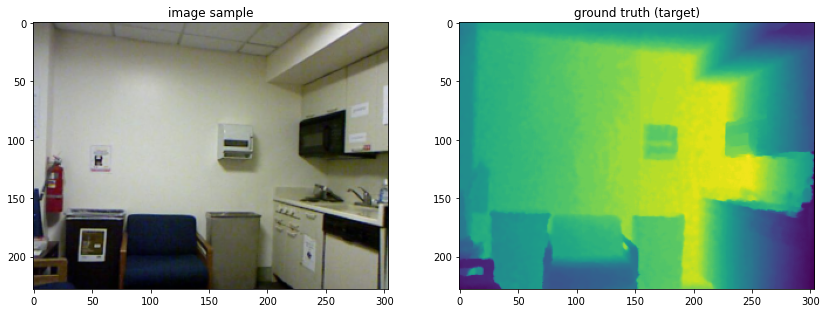

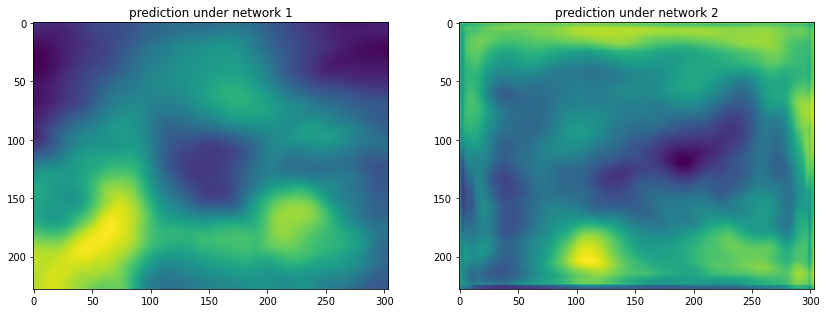

In [ ]:
untrained_net1=DepthNetwork(loss = training_loss1).eval().double()
untrained_net2=AdvancedNetwork(loss = training_loss2).eval().double()

inp = torch.Tensor(test_imgs[0][None]).double()

out1 = untrained_net1(inp)
out1 = out1[0]

out2 = untrained_net2(inp)
out2 = out2[0]

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample')
img = np.transpose(test_imgs[0], (1,2,0))
ax.imshow(img)

ax = fig.add_subplot(1,2,2)
plt.title('ground truth (target)')
target = test_targets[0]
ax.imshow(target)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('prediction under network 1')
ax.imshow(out1.cpu().detach().numpy())

ax = fig.add_subplot(1,2,2)
plt.title('prediction under network 2')
ax.imshow(out2.cpu().detach().numpy())



In [ ]:
print_evaluation([untrained_net1, untrained_net2], overfit_dloader)
#print_evaluation([untrained_net1, untrained_net2], train_dloader)
#print_evaluation([untrained_net1, untrained_net2], test_dloader)

The overfit_dloader only contains one image. As a result, it so happens the threshold evaluation is actually good, unless $\delta$ is small.

## Optimizer and Training Code

In [ ]:
def get_optimizer(net,lr=0.0001):
    params = net.parameters()
    optimizer = torch.optim.Adam(params, lr=lr)

    return optimizer

def train(data_loader, net, optimizer, loss_graph):
    net.train()
    
    for i, data in enumerate(data_loader):
        
        inputs, masks = data
       
        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            masks = masks.cuda()
        
        optimizer.zero_grad()
        main_loss = net(inputs, masks)
        
        main_loss.backward()
        optimizer.step()
        

    return main_loss


def training_loop(net, loader, optimizer, EPOCH=20, print_epochs_mod=1):
  net = net.train()
  for e in range(EPOCH):
    l = train(loader, net, optimizer, None)
    if e % print_epochs_mod == 0: 
      print("Epoch ", e, ": ", l.item())



## Evaluation of the First Network

### Training the First Network

In [ ]:
net1=DepthNetwork(loss = training_loss1).double()
net1.train()

# Overfit
#optimizer = get_optimizer(net1, lr=0.01)
#training_loop(net1, overfit_dloader, optimizer, EPOCH=50, print_epochs_mod=5)

# Training Set
optimizer = get_optimizer(net1, lr=0.001)
training_loop(net1, train_dloader, optimizer, EPOCH=10, print_epochs_mod=1)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch  0 :  0.3097141680637732
Epoch  1 :  0.20380133953397347
Epoch  2 :  0.1194187151015757
Epoch  3 :  0.35826446657380423
Epoch  4 :  0.0864853689979702
Epoch  5 :  0.07448278226530947
Epoch  6 :  0.1049929120899521
Epoch  7 :  0.05258951457805205
Epoch  8 :  0.07950567944667786
Epoch  9 :  0.0639833439223787


### Qualitative results for training and test set

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


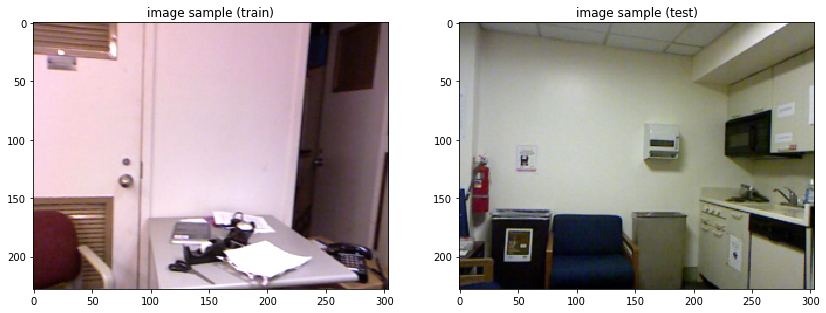

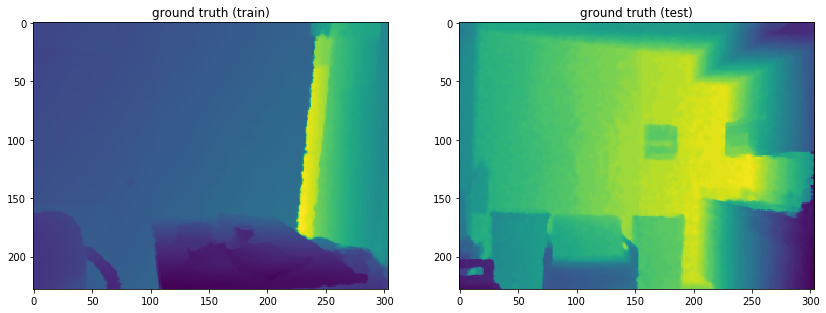

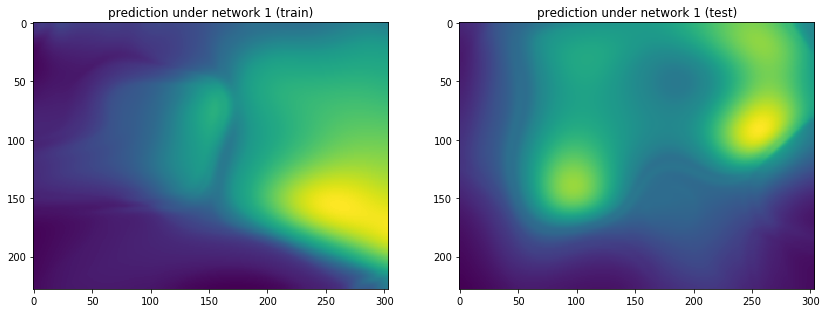

In [ ]:
inp_tr = torch.Tensor(train_imgs[0][None]).double()
inp_te = torch.Tensor(test_imgs[0][None]).double()


if USE_GPU:
  inp_tr = inp_tr.cuda()
  inp_te = inp_te.cuda()
  

out1_tr = net1(inp_tr)
out1_tr = out1_tr[0]

out1_te = net1(inp_te)
out1_te = out1_te[0]

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample (train)')
img = np.transpose(train_imgs[0], (1,2,0))
ax.imshow(img)

ax = fig.add_subplot(1,2,2)
plt.title('image sample (test)')
img = np.transpose(test_imgs[0], (1,2,0))
#target = train_targets[0]
ax.imshow(img)


fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('ground truth (train)')
target = train_targets[0]
ax.imshow(target)

ax = fig.add_subplot(1,2,2)
plt.title('ground truth (test)')
target = test_targets[0]
ax.imshow(target)


fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('prediction under network 1 (train)')
ax.imshow(out1_tr.cpu().detach().numpy())

ax = fig.add_subplot(1,2,2)
plt.title('prediction under network 1 (test)')
ax.imshow(out1_te.cpu().detach().numpy())



### Evaluation Metrics on Test Dataset for First Network

In [ ]:
#print_evaluation([net1], loader=overfit_dloader)
print_evaluation([net1], loader=test_dloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Model DepthNetwork : 
	(delta=1.5)	 0.8264920654838045 
	(delta=1.5^2)	 0.9821965333017073 
	(delta=1.5^3)	 0.9987756686249262


In [ ]:
print_RMSE_loss([net1], loader=test_dloader)
#print_RMSE_loss([net1], loader=overfit_dloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Model DepthNetwork : 	 0.8831230674940893


### Analysis of First Network

The network performs very well with all three thresholds. The MSE loss function guarantees that predictions are relatively close. Surprisingly, the results appear just as good as from [2]. This is misleading, as we see the qualitative results from above are not as strong as they could be. The RMSE evaluation for the test set performs worse than what is found in [1][2][4]. We see this qualitatively: although there are significant blobs recognizing areas with small or large depth (dark blue v.s. green), it doesn't fully get the shape quite right. This suggests the network is not overfitting, as the test results look okay, but perhaps underfitting.  

The network is getting results that are close enough, but generally not enough pixels are making good predictions so that the overall prediction looks like the target. The advantage of this network is that it trains quickly (2-3 mins per epoch) and produces respectable results. The network may be improved if skip connections similar to that found in [1] are implemented, the training runs for more epochs, and more layers to the network are added. If such changes lead to overfitting, various generalization techniques like dropout can be added and tested, and more image augmentations suggested by [1] can be added.

## Evaluation of the Second Network

### Training the Second Network

In [ ]:
net2=AdvancedNetwork(loss = training_loss2).eval().double()
net2.train()

# Overfit
#optimizer = get_optimizer(net2, lr=0.05)
#training_loop(net2, overfit_dloader, optimizer, EPOCH=50, print_epochs_mod=5)

# Training Set
optimizer = get_optimizer(net2, lr=0.001)
training_loop(net2, train_dloader, optimizer, EPOCH=10)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch  0 :  0.2223238636375461
Epoch  1 :  0.14263821348577432
Epoch  2 :  0.27577745956870786
Epoch  3 :  0.14990668014814956
Epoch  4 :  0.15897810041380944
Epoch  5 :  0.18599402053985098
Epoch  6 :  0.13977973376904512
Epoch  7 :  0.14169341447455014
Epoch  8 :  0.06740168055366087
Epoch  9 :  0.09729571598238865


### Qualitative results for training and test set

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


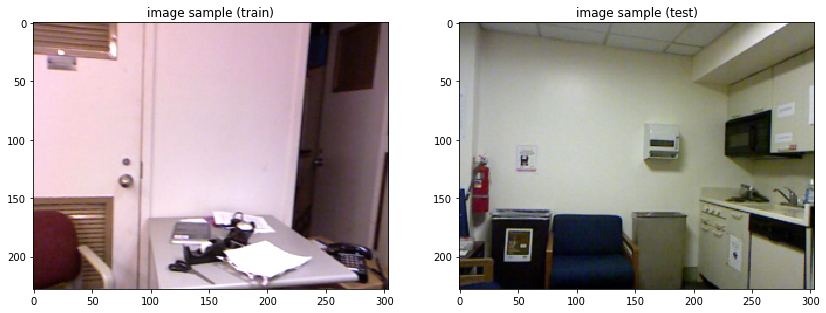

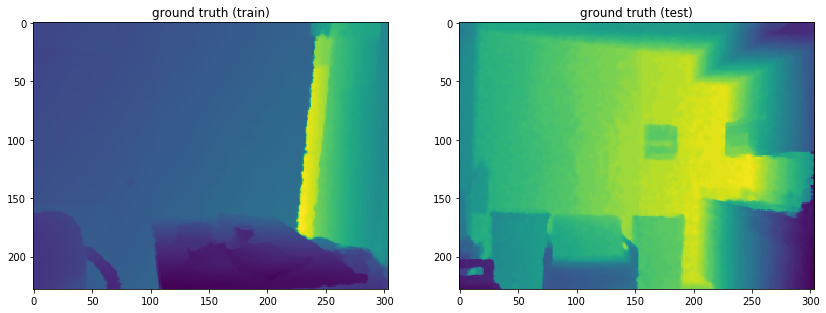

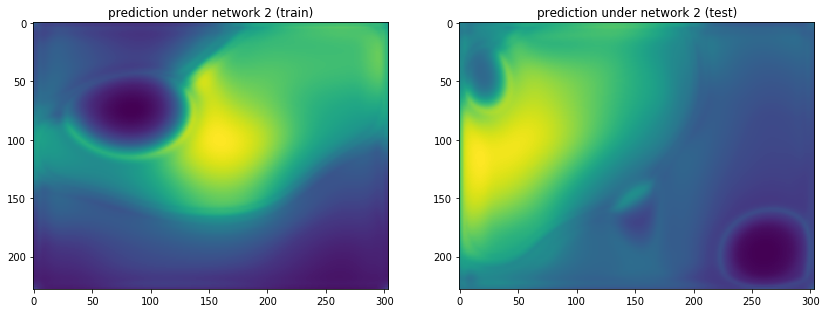

In [ ]:
inp_tr = torch.Tensor(train_imgs[0][None]).double()
inp_te = torch.Tensor(test_imgs[0][None]).double()


if USE_GPU:
  inp_tr = inp_tr.cuda()
  inp_te = inp_te.cuda()
  net2 = net2.cuda()
  

out2_tr = net2(inp_tr)
out2_tr = out2_tr[0]

out2_te = net2(inp_te)
out2_te = out2_te[0]

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('image sample (train)')
img = np.transpose(train_imgs[0], (1,2,0))
ax.imshow(img)

ax = fig.add_subplot(1,2,2)
plt.title('image sample (test)')
img = np.transpose(test_imgs[0], (1,2,0))
ax.imshow(img)


fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('ground truth (train)')
target = train_targets[0]
ax.imshow(target)

ax = fig.add_subplot(1,2,2)
plt.title('ground truth (test)')
target = test_targets[0]
ax.imshow(target)


fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,2,1)
plt.title('prediction under network 2 (train)')
ax.imshow(out2_tr.cpu().detach().numpy())

ax = fig.add_subplot(1,2,2)
plt.title('prediction under network 2 (test)')
ax.imshow(out2_te.cpu().detach().numpy())



### Evaluation Metrics on Test Dataset for Second Network

In [ ]:
#print_evaluation([net2], loader=overfit_dloader)
print_evaluation([net2], loader=test_dloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Model AdvancedNetwork : 
	(delta=1.5)	 0.698906253088459 
	(delta=1.5^2)	 0.9416182837485639 
	(delta=1.5^3)	 0.9913844123880037


In [ ]:
print_RMSE_loss([net2], loader=test_dloader)
#print_RMSE_loss([net2], loader=overfit_dloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Model AdvancedNetwork : 	 1.2475451232466592


### Analysis of Second Network

The network performs very well with the thresholds $\delta_2 = 1.5^2$ and $\delta_3=1.5^3$. However, for $\delta_1 = 1.5$, the results are not strong. We can connect this with the qualitative results: there are dark blue and green blobs that are generally in the right place,  but in some places they are quite wrong. The RMSE is fairly larger than those of Eigen and Fergus [1] and Laina et al. [2], but not significantly larger than my first network. The outputs of the second network have dark blue blobs with distinct round edges, unlike for the first network. This is somewhat reflective of the targets, as there are sharp transitions of depth, but the overall shape and location of these blobs are generally wrong.

Improvements suggested for network 1 can be made for 2 as well. As it is clearly not converging, following the second paper more closely and playing with hyperparameters would be necessary to help figure out what is going wrong here. Visualizing convolutional layers may be helpful for debugging as well. The network trained for around 4-5 minutes per epoch, as a result of the upsampling being more sophisticated. To improve this, the authors of [3] instead used the upsampling technique found in Figure 3 (d), because it is "the faster equivalent" of what is found in Figure 3 (c). 

# 6. Conclusion

The first network performs well with respect to the evaluation metrics. The predictions themselves were only mildly satisfactory. It provides a good starting point for a simple yet effective network. The second network, despite being a network with more parameters, doesn't perform well by underfitting. 

Based on the outputs of the two networks, it seems generally it can detect regions where the images have large or small depth, even on test images. The underfitting is still a concern. Both networks serve as a satisfactory starting point, which can be improved upon. For instance, adding more skip connections or more layers to the networks (so long as generalization techniques are considered). A more careful analysis is necessary to see why the second network is not converging. 


# References


[1] D.  Eigen,  C.  Puhrsch,  and  R.  Fergus,  “Depth  map  prediction  from  a  single  image  using  a multi-scale deep network,” CoRR, vol. abs/1406.2283, 2014.


[2] I. Laina, C. Rupprecht, V. Belagiannis, F. Tombari, and N. Navab, “Deeper depth prediction with fully convolutional residual networks,” 2016.

[3] P. K. Nathan Silberman, Derek Hoiem and R. Fergus. Indoor segmentation and support inference
from RGBD images. In ECCV, 2012

[4]  D. Eigen and R. Fergus, "Predicting depth, surface normals and semantic labels with a common multi-scale convolutional architecture," CoRR, vol. abs/1411.4734, 2014.

[5] J. Deng, W. Dong, R. Socher, L. Li, K. Li, and L. Fei-fei. Imagenet: A large-scale hierarchical
image database. In CVPR, 2009.


# Appendix : Additional unused code for reference

## 1. Verbatim Recreation of Network from [1]

In [ ]:
raise NotImplementedError

# The Coarse Network from Figure 1. Should be pretrained on ImageNet.
class CoarseNetwork(nn.Module):
    def __init__(self, criterion=None):
        super(CoarseNetwork, self).__init__()

        if criterion is not None:
          self.criterion = criterion()
        
        self.convA1 = nn.Conv2d(3, 96, 11, stride=4, padding=0, dilation=1)
        self.maxpool1 = nn.MaxPool2d(2, stride=None, padding=0, dilation=1)
        
        self.convA2 = nn.Conv2d(96, 256, 5, stride=1, padding=2, dilation=1)
        self.maxpool2 = nn.MaxPool2d(2,stride=None, padding=0, dilation=1)
        
        self.convA3 = nn.Conv2d(256, 384, 3, stride=1, padding=1, dilation=1)
        
        self.convA4 = nn.Conv2d(384, 384, 3, stride=1, padding=1, dilation=1)
        
        self.convA5 = nn.Conv2d(384, 256, 3, stride=1, padding=1, dilation=1)
        self.maxpool3 = nn.MaxPool2d(2,stride=None, padding=0, dilation=1)
        
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(256*9*6, 4096)
        
        self.fc2 = nn.Linear(4096, 74*55)

    def forward(self, inp, gts=None):

        y = self.convA1(inp)
        y = self.maxpool1(y)
        y = F.relu(y)
        
        y = self.convA2(y)
        y = self.maxpool2(y)
        y = F.relu(y)
        
        y = self.convA3(y)
        y = F.relu(y)
        
        y = self.convA4(y)
        y = F.relu(y)
        
        y = self.convA5(y)
        y = self.maxpool3(y)
        y = F.relu(y)
      
        y = self.flat(y) #self.mean(1)?
        y = self.fc1(y)
        y = F.relu(y)
        
        y = self.fc2(y)
        y = y.view(-1, 1, 55, 74)
        
        if gts is not None:
            # Return the loss if in training mode
            return self.criterion(y, gts)              
        else:
            # Return the actual prediction otherwise
            return y

# The Fine Network, which makes the prediction.
class Old_DepthNetwork(nn.Module):
    def __init__(self, loss=None):
        super(Old_DepthNetwork, self).__init__()

        self.loss = loss
        self.coarse = CoarseNetwork1()

        
        self.convB1 = nn.Conv2d(3, 63, 9, stride=2, padding=0, dilation=1)
        self.maxpoolB1 = nn.MaxPool2d(2)
        
        self.convB2 = nn.Conv2d(64, 64, 5, stride=1, padding=2, dilation=1)
        
        self.convB3 = nn.Conv2d(64, 32, 5, stride=1, padding=2, dilation=1)

        self.convB4 = nn.Conv2d(32, 1, 1, stride=1, padding=0, dilation=1)

    
    def forward(self, inp, target=None):

        y = self.coarse.forward(inp)
       
        x = self.convB1(inp)
        x = self.maxpoolB1(x)
        x = F.relu(x)

        x = torch.cat((x,y), 1)

        x = self.convB2(x)
        x = F.relu(x)
        
        x = self.convB3(x)
        x = F.relu(x)
        
        x = F.interpolate(x, size=(228,304), mode='bilinear')
        
        x =self.convB4(x)

        x = x.mean(1) # Reduce dim

        if target is not None:
          
          return self.loss(x, torch.log(target))
        
        else:
          return torch.exp(x)
        